Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/MyDrive/Colab Notebooks/electric_vehicles_spec_2025.csv.csv'
Columns retained after variance thresholding: ['top_speed_kmh', 'battery_capacity_kWh', 'number_of_cells', 'torque_nm', 'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc', 'towing_capacity_kg', 'length_mm', 'width_mm']
New shape after variance filtering: (478, 10)


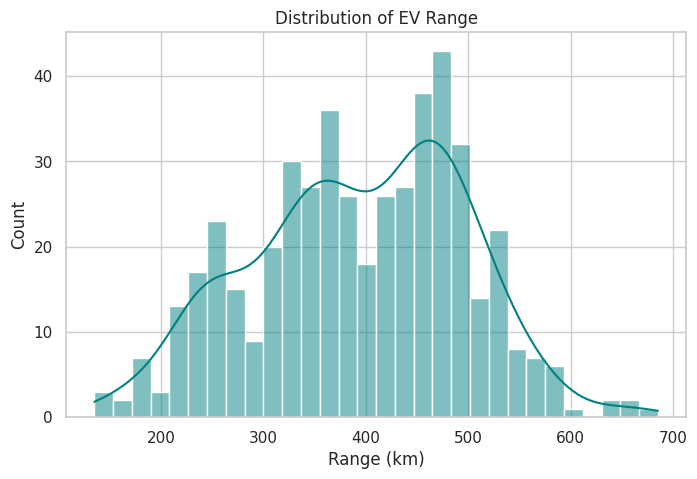

Top correlated features with range_km:
 Index(['range_km', 'battery_capacity_kWh', 'top_speed_kmh',
       'fast_charging_power_kw_dc', 'acceleration_0_100_s', 'torque_nm'],
      dtype='object')


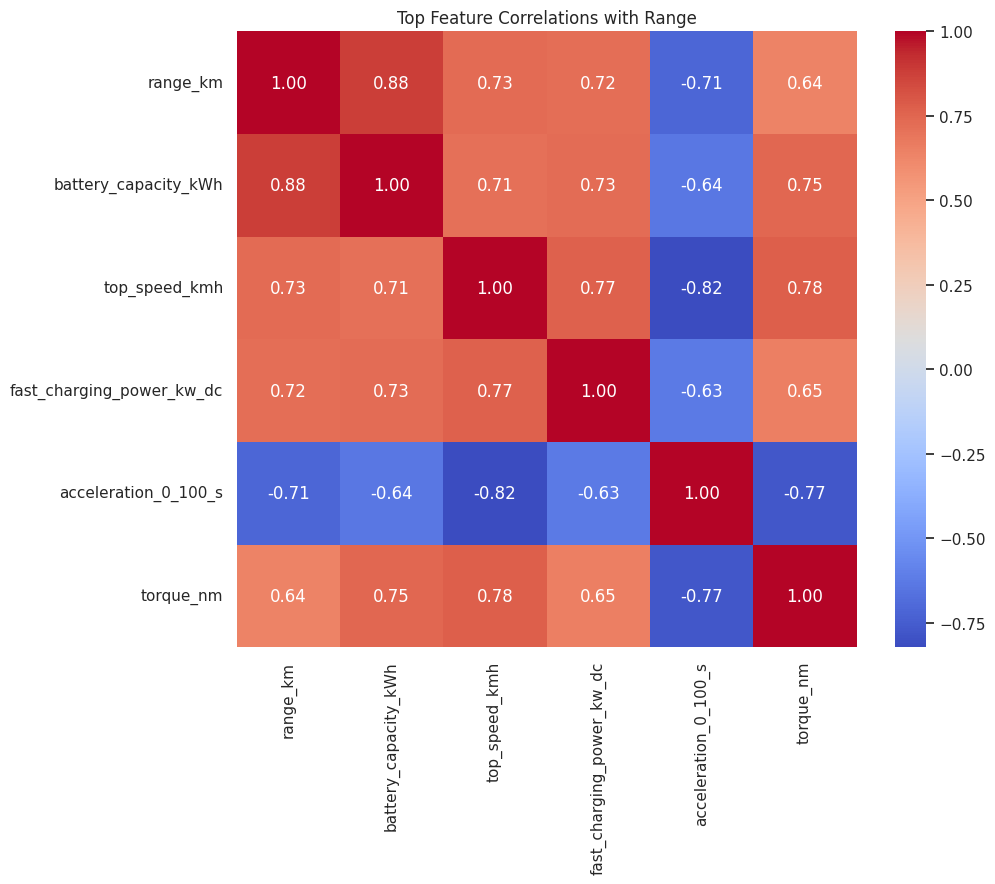

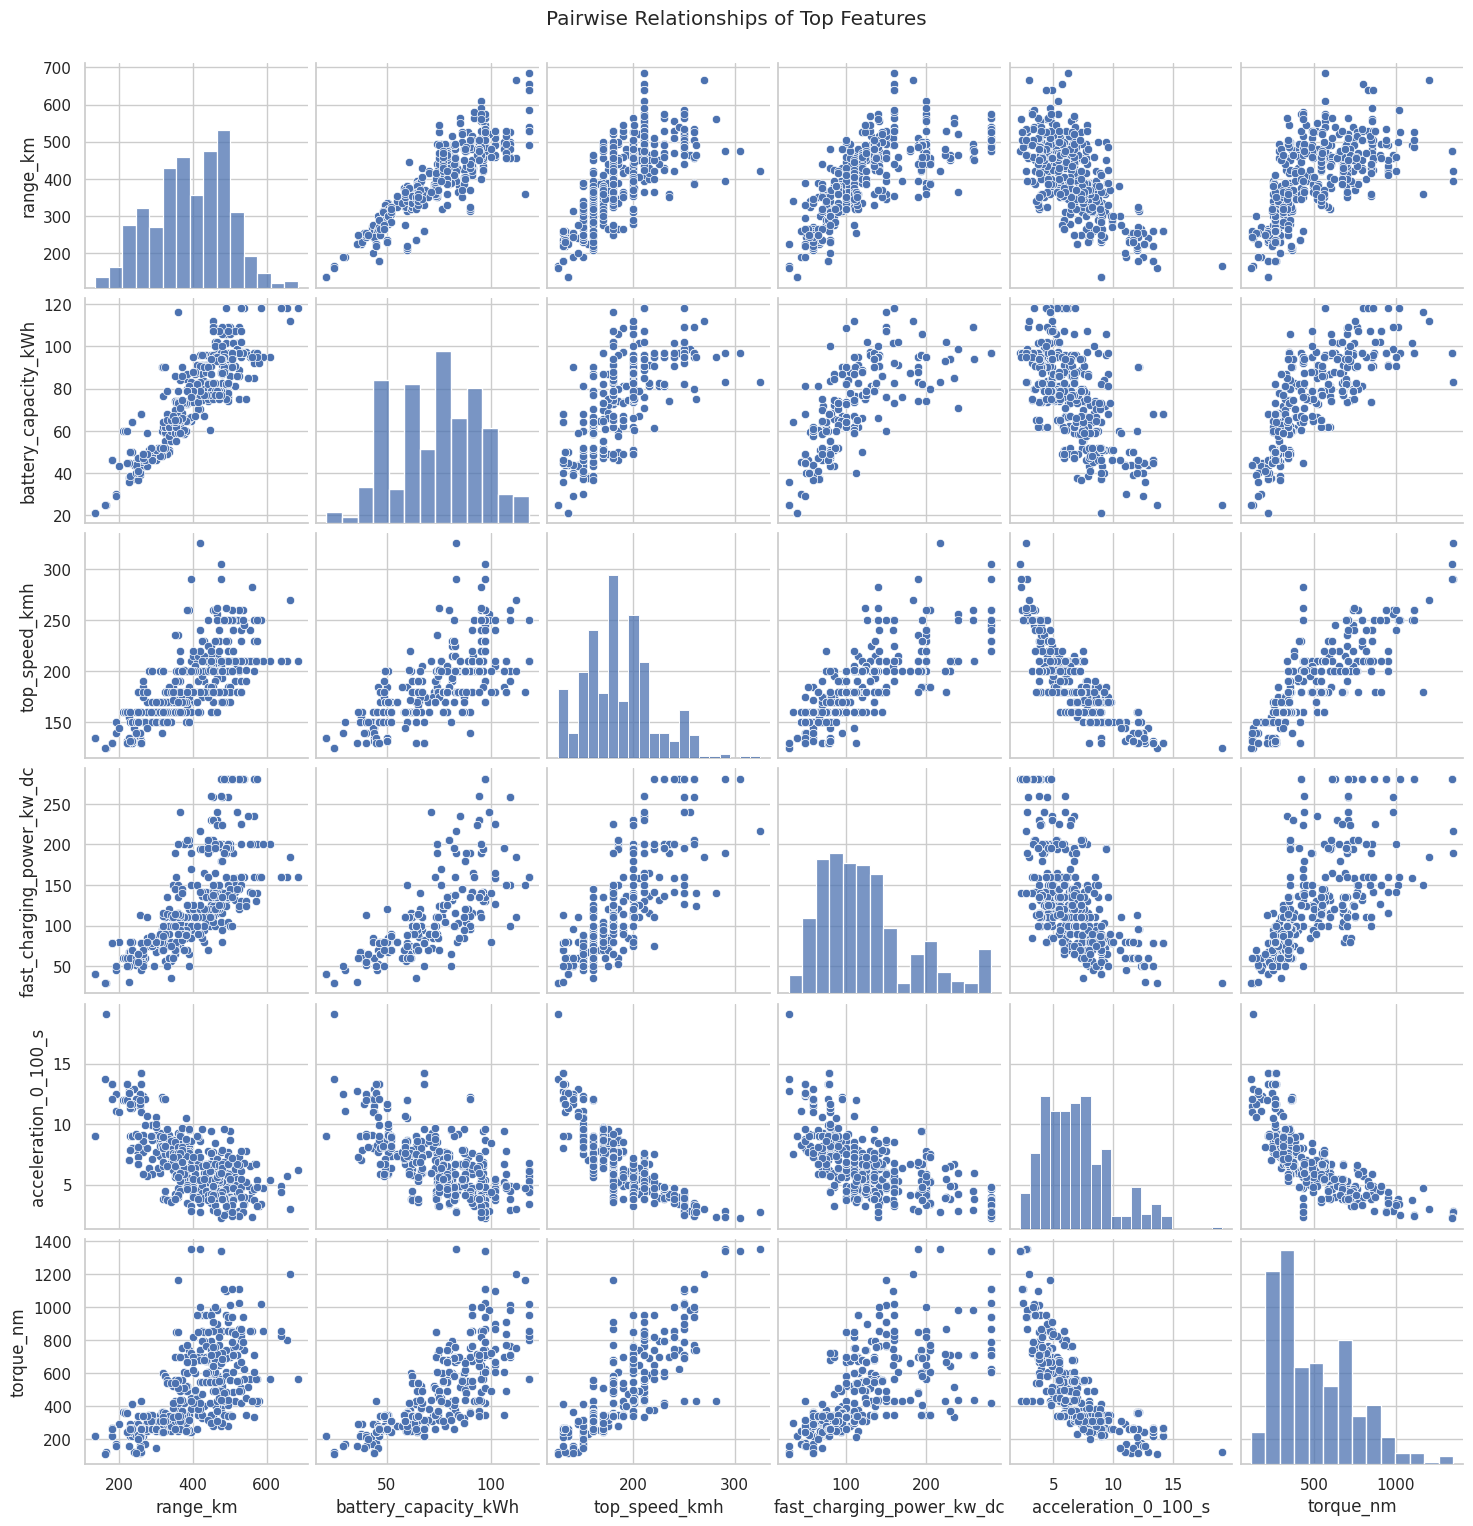

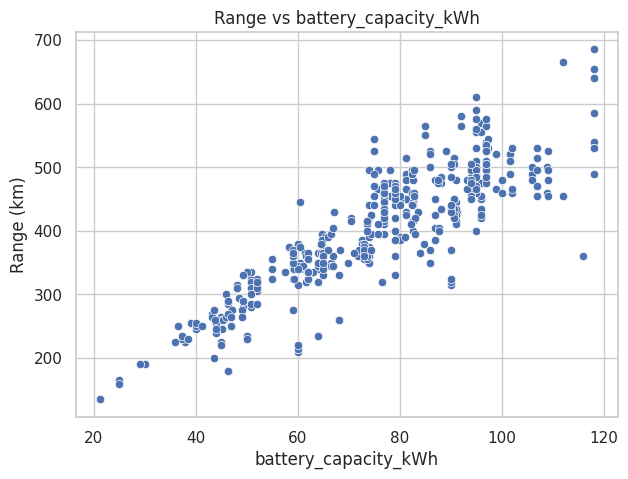

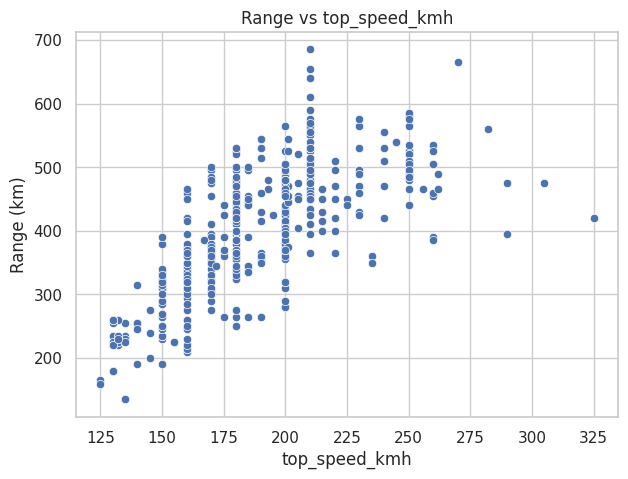

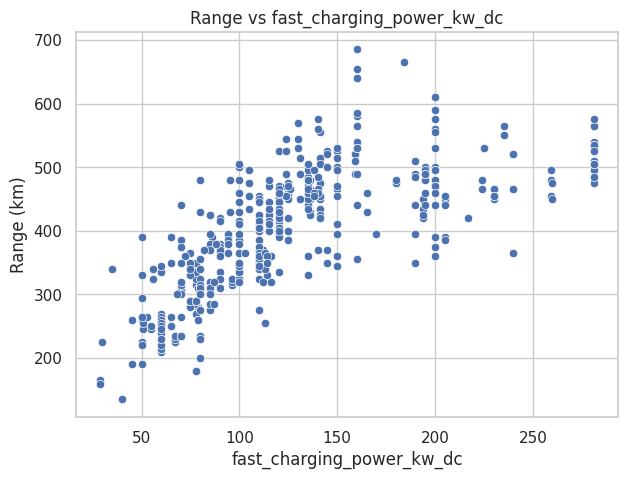

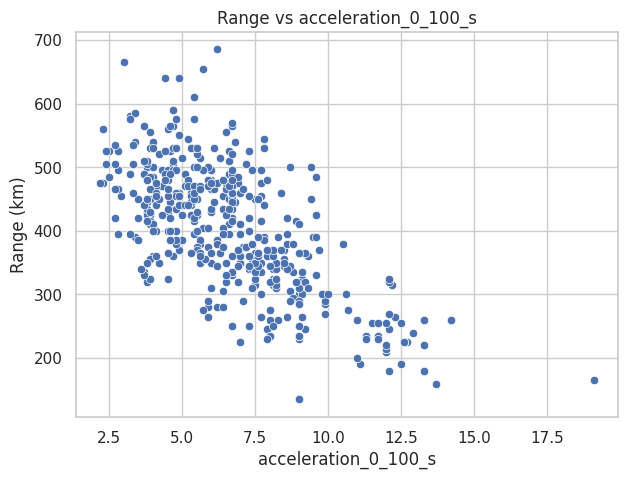

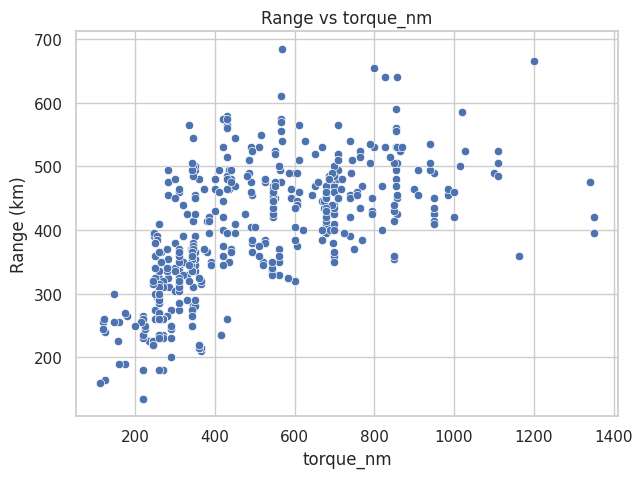

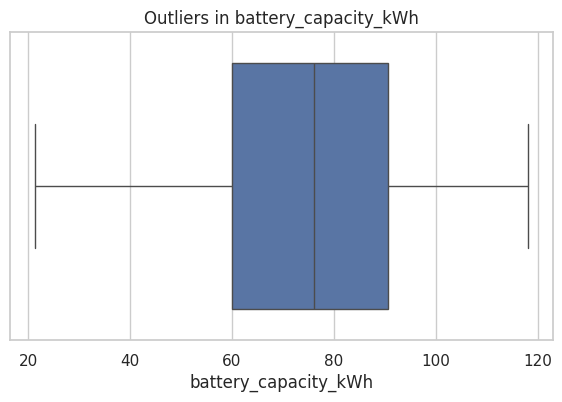

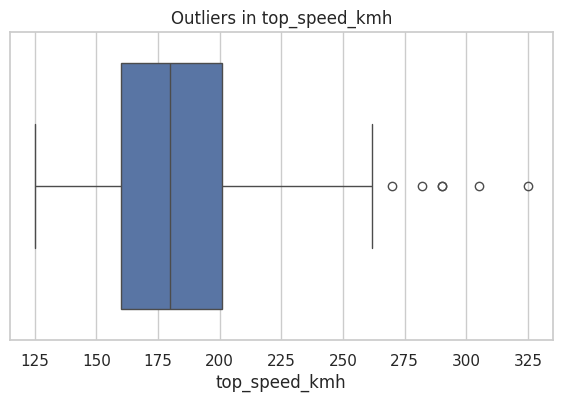

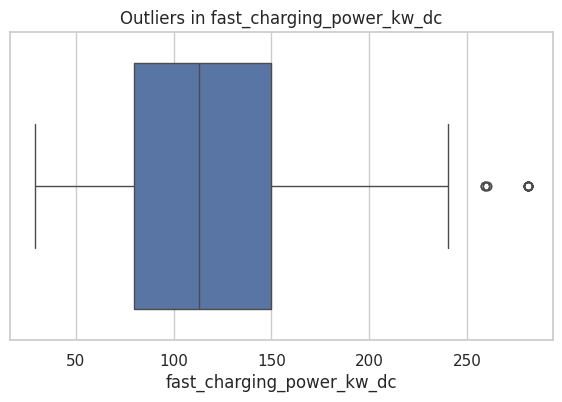

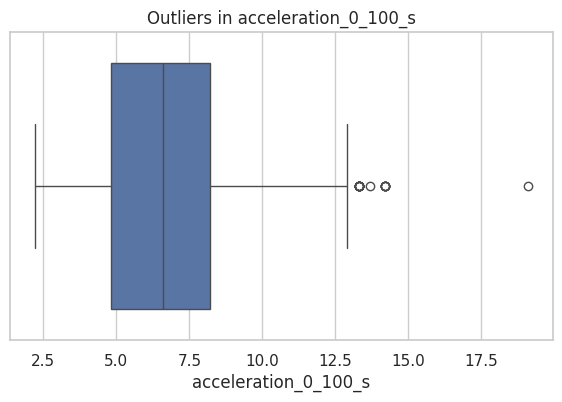

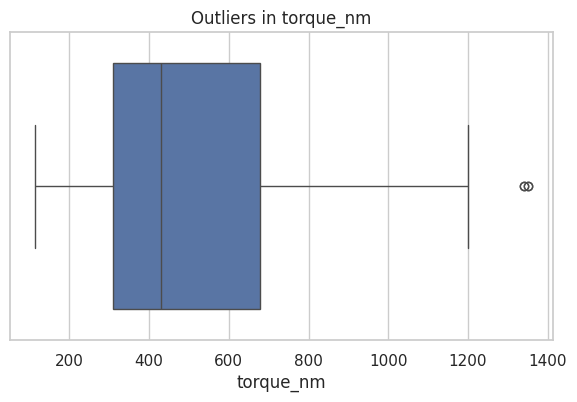

Model Performance Comparison:



,R²,MAE,RMSE
Linear Regression,0.861709,31.085994,38.253939
Decision Tree,0.893199,22.265625,33.617603
Random Forest,0.931940,19.794013,26.836435


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best R² from Cross Validation: 0.9070795827509338

Optimized Random Forest Model Performance:
R²: 0.933189885196769
MAE: 0.19177818113913583
RMSE: 0.2576960416817751


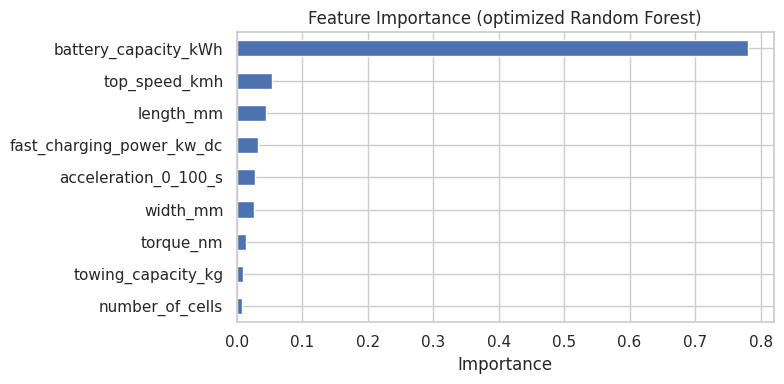

Saved model -> optimized_rf_model.pkl
Saved feature list -> model_features.pkl
Drive folder not found (no /content/drive/MyDrive/EV_ML_Project). If you want Drive backup, mount Drive and create that folder.


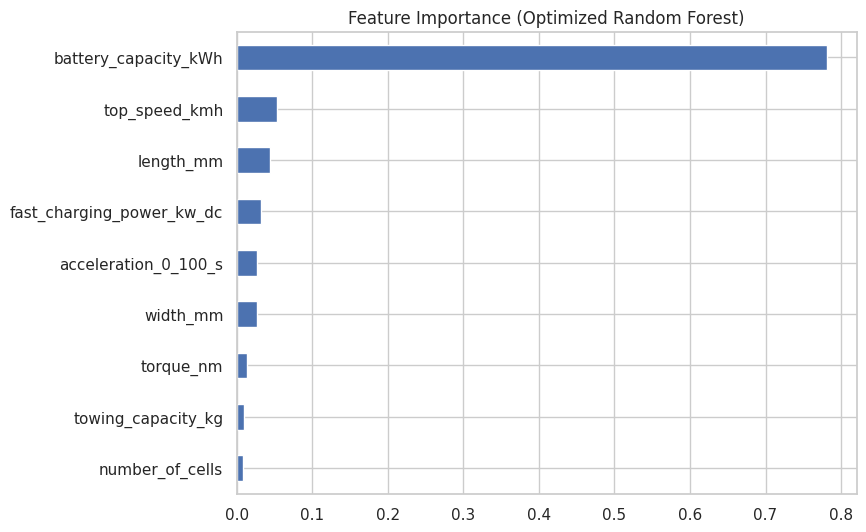

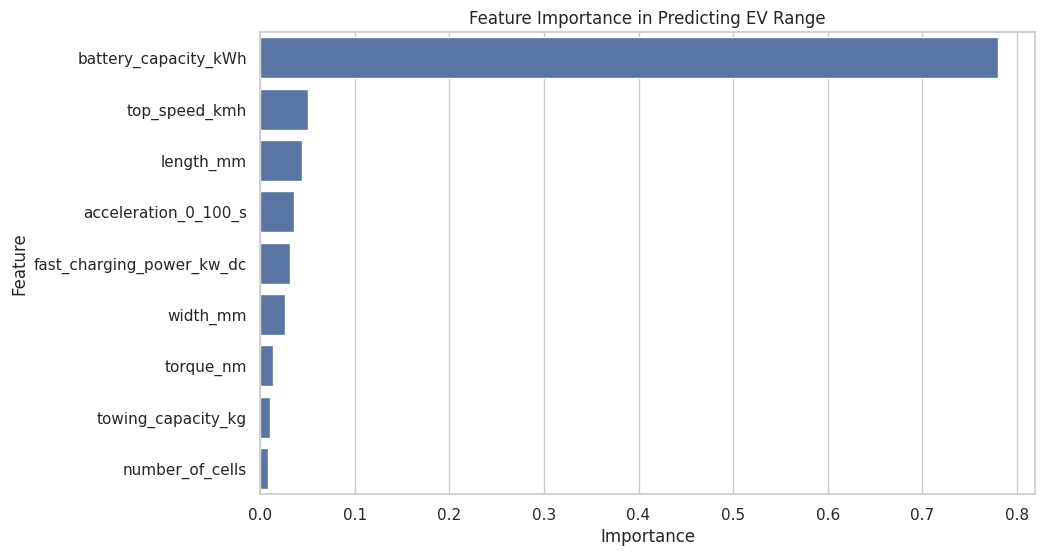

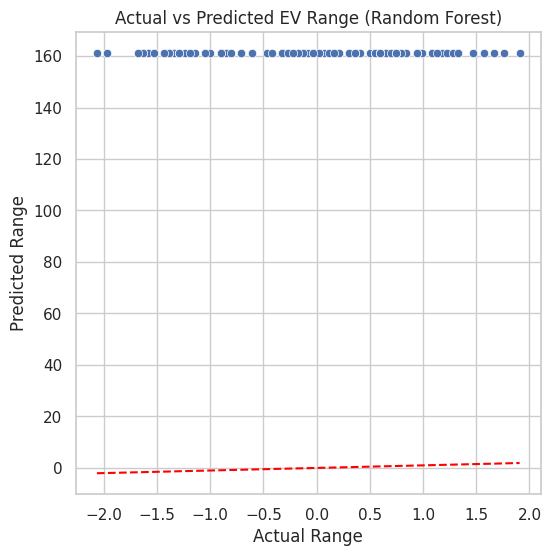

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/Colab\ Notebooks/electric_vehicles_spec_2025.csv.csv

import pandas as pd
path = '/content/drive/MyDrive/Colab Notebooks/electric_vehicles_spec_2025.csv.csv'
df = pd.read_csv(path)





from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

# Load the dataset


# Handling missing data
df['number_of_cells'] = df['number_of_cells'].fillna(df['number_of_cells'].median())
df['towing_capacity_kg'] = df['towing_capacity_kg'].fillna(df['towing_capacity_kg'].median())
df['torque_nm'] = df['torque_nm'].fillna(df['torque_nm'].median())

# Drop columns that are not useful
df.drop(['model'], axis=1, inplace=True)

# Impute numerical columns with median
df['fast_charging_power_kw_dc'] = df['fast_charging_power_kw_dc'].fillna(df['fast_charging_power_kw_dc'].median())
df['cargo_volume_l'] = pd.to_numeric(df['cargo_volume_l'], errors='coerce')
df['cargo_volume_l'] = df['cargo_volume_l'].fillna(df['cargo_volume_l'].median())

# Impute categorical columns with mode
df['fast_charge_port'] = df['fast_charge_port'].fillna(df['fast_charge_port'].mode()[0])

# Drop other non-numeric columns
df.drop(['source_url', 'brand', 'battery_type'], axis=1, inplace=True, errors='ignore')


# Handling categorical data and dropping first category to eliminate redundancy
df = pd.get_dummies(df, columns=['drivetrain', 'segment', 'car_body_type'], drop_first=True)

# Drop weak and redundant features (based on previous analysis)
cols_to_drop = [
    'efficiency_wh_per_km', 'cargo_volume_l', 'seats', 'height_mm',
    # weak or redundant dummy columns (check if they exist after get_dummies)
    'segment_G - Sports', 'segment_I - Luxury', 'segment_JC - Medium', 'segment_JA - Mini',
    'segment_B - Compact', 'segment_N - Passenger Van', 'car_body_type_Small Passenger Van'
]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True, errors='ignore')

# Feature selection using variance threshold
# Ensure only numeric columns are selected before applying VarianceThreshold
df_numeric_for_variance = df.select_dtypes(include=np.number)
selector = VarianceThreshold(threshold=0.01)
selector.fit(df_numeric_for_variance)
retained_cols_after_variance = df_numeric_for_variance.columns[selector.get_support()]

# Filter the main dataframe to keep only retained columns and the target variable
# Make sure 'range_km' is included even if its variance is low (it's the target)
if 'range_km' not in retained_cols_after_variance:
  retained_cols_after_variance = retained_cols_after_variance.tolist() + ['range_km']


df = df[retained_cols_after_variance]


print("Columns retained after variance thresholding:", retained_cols_after_variance.tolist())
print("New shape after variance filtering:", df.shape)
df.head(10)
# backup dataframe
df_cleaned = df.copy()

# ------------------------------------------------------------------------------------------------------------------------------------------------
# EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------------------------------------------------------------------------------------------

sns.set(style="whitegrid")

# Target Variable Distribution(range)
plt.figure(figsize=(8,5))
sns.histplot(df['range_km'], bins=30, kde=True, color='teal')
plt.title('Distribution of EV Range')
plt.xlabel('Range (km)')
plt.ylabel('Count')
plt.show()

# Identify Top Correlated Features
# Ensure correlation is computed on numeric data only
corr_matrix = df.select_dtypes(include=np.number).corr()
top_corr_features = corr_matrix['range_km'].abs().sort_values(ascending=False).head(6).index
print("Top correlated features with range_km:\n", top_corr_features)

# Plot Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr_features].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Top Feature Correlations with Range")
plt.show()

# Pairwise Scatterplots for Top Features
sns.pairplot(df[top_corr_features])
plt.suptitle("Pairwise Relationships of Top Features", y=1.02)
plt.show()

# Individual Relationship with Range (Scatterplots)
for feature in top_corr_features:
    if feature != 'range_km':
        plt.figure(figsize=(7,5))
        sns.scatterplot(x=df[feature], y=df['range_km'])
        plt.title(f'Range vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Range (km)')
        plt.show()

# Boxplots to Detect Outliers
# Ensure numeric_features are from the current df after feature selection
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in top_corr_features: # Iterate through top correlated features
    if feature != 'range_km' and feature in numeric_features: # Check if feature is in current numeric features
        plt.figure(figsize=(7,4))
        sns.boxplot(x=df[feature])
        plt.title(f'Outliers in {feature}')
        plt.show()


# Model selection and training
# ----------------------------------------------------------------------------------------------------------------------------------------------------

# Split the dataset into features (X) and target (y)
X = df.drop('range_km', axis=1)  # Use the correct column name 'range_km'
y = df['range_km'] # Use the correct column name 'range_km'

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {"R²": r2, "MAE": mae, "RMSE": rmse}

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:\n")
display(results_df)


# ================================================
# Step: Model Optimization (Random Forest)
# ================================================

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Feature Scaling ---
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# --- Split again to ensure consistency ---
X = df.drop('range_km', axis=1)
y = df['range_km']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Hyperparameter Tuning ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R² from Cross Validation:", grid_search.best_score_)

# --- Final Model Evaluation ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nOptimized Random Forest Model Performance:")
print(f"R²: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


## Save Final Model & Feature List (for deployment)


# --------------------------
# Save optimized model & feature list, and plot feature importances
# --------------------------

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find the optimized model object in the current session
model = None

# Prefer common variable names that we used earlier
if 'grid_search' in globals() and hasattr(grid_search, 'best_estimator_'):
    model = grid_search.best_estimator_
elif 'best_model' in globals():
    model = best_model
elif 'best_rf' in globals():
    model = best_rf
elif 'rf' in globals():
    model = rf
elif 'models' in globals() and isinstance(models, dict) and 'Random Forest' in models:
    model = models['Random Forest']

if model is None:
    raise RuntimeError("Could not find the trained Random Forest model in this session. Please re-run the training or set 'best_model' to your final estimator.")

# 2) Get feature names the model expects
if 'X_train' in globals():
    feature_names = list(X_train.columns)
elif hasattr(model, 'feature_names_in_'):
    feature_names = list(model.feature_names_in_)
else:
    # Fallback: use df columns excluding target (assumes df still in memory)
    feature_names = [c for c in df.columns if c != 'range_km']

# 3) Plot feature importances (if available)
if hasattr(model, 'feature_importances_'):
    importances = np.array(model.feature_importances_)
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(8, max(4, 0.25*len(fi))))
    fi.plot(kind='barh')
    plt.title('Feature Importance (optimized Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print("Model has no attribute 'feature_importances_'. Skipping importance plot.")

# 4) Save model and feature list to local disk and to Drive if mounted
model_filename_local = "optimized_rf_model.pkl"
features_filename_local = "model_features.pkl"

joblib.dump(model, model_filename_local)
joblib.dump(feature_names, features_filename_local)
print(f"Saved model -> {model_filename_local}")
print(f"Saved feature list -> {features_filename_local}")

# If Google Drive is mounted, also save a copy there for persistence
drive_folder = "/content/drive/MyDrive/EV_ML_Project"
if os.path.exists(drive_folder):
    joblib.dump(model, os.path.join(drive_folder, model_filename_local))
    joblib.dump(feature_names, os.path.join(drive_folder, features_filename_local))
    print(f"Also saved copies to Drive at: {drive_folder}")
else:
    print("Drive folder not found (no /content/drive/MyDrive/EV_ML_Project). If you want Drive backup, mount Drive and create that folder.")



## Final Note — Model Saved for Deployment

# - The optimized Random Forest model and the ordered list of features have been saved as:
#   - `optimized_rf_model.pkl`
#   - `model_features.pkl`

# - If Google Drive is mounted at `/content/drive/MyDrive/EV_ML_Project/`, copies are saved there as well.

# - These files will be loaded by the Streamlit app (Week 3) so the UI/chatbot can quickly make predictions without retraining.

# --- Feature Importance Visualization ---
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance (Optimized Random Forest)")
plt.show()






# Step 6: Model Evaluation & Visualization
#---------------------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Choose the best model (Random Forest)
best_model = models["Random Forest"]

# Feature importance plot
importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Predicting EV Range')
plt.show()

# Actual vs Predicted plot
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Range")
plt.ylabel("Predicted Range")
plt.title("Actual vs Predicted EV Range (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [ ]:
df.head(10)

,top_speed_kmh,battery_capacity_kWh,number_of_cells,torque_nm,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,length_mm,width_mm
0,155,37.8,192.0,235.0,225,7.0,67.0,0.0,3673,1683
1,155,37.8,192.0,235.0,225,7.0,67.0,0.0,3673,1683
2,200,50.8,102.0,345.0,280,5.9,79.0,0.0,4187,1779
3,200,50.8,102.0,345.0,280,6.2,79.0,0.0,4187,1779
4,150,60.0,216.0,310.0,315,7.5,78.0,1000.0,4680,1865
5,160,60.0,216.0,315.0,350,7.0,78.0,1000.0,4805,1880
6,150,50.8,102.0,260.0,320,9.0,85.0,0.0,4173,1781
7,200,50.8,102.0,345.0,310,6.0,85.0,0.0,4173,1781
8,160,52.0,184.0,285.0,310,7.4,70.0,500.0,3997,1823
9,170,52.0,184.0,300.0,305,6.4,70.0,500.0,3997,1823


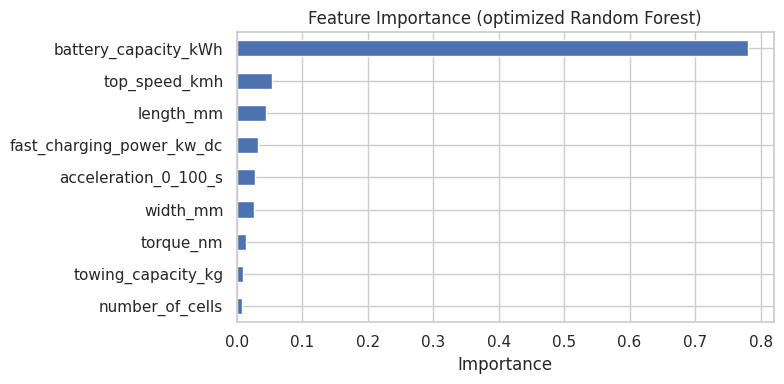

Saved model -> optimized_rf_model.pkl
Saved feature list -> model_features.pkl
Drive folder not found (no /content/drive/MyDrive/colabnotebooks/EV_Range_Prediction). If you want Drive backup, mount Drive and create that folder.


In [3]:
# --------------------------
# Save optimized model & feature list, and plot feature importances
# --------------------------

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find the optimized model object in the current session
model = None

# Prefer common variable names that we used earlier
if 'grid_search' in globals() and hasattr(grid_search, 'best_estimator_'):
    model = grid_search.best_estimator_
elif 'best_model' in globals():
    model = best_model
elif 'best_rf' in globals():
    model = best_rf
elif 'rf' in globals():
    model = rf
elif 'models' in globals() and isinstance(models, dict) and 'Random Forest' in models:
    model = models['Random Forest']

if model is None:
    raise RuntimeError("Could not find the trained Random Forest model in this session. Please re-run the training or set 'best_model' to your final estimator.")

# 2) Get feature names the model expects
if 'X_train' in globals():
    feature_names = list(X_train.columns)
elif hasattr(model, 'feature_names_in_'):
    feature_names = list(model.feature_names_in_)
else:
    # Fallback: use df columns excluding target (assumes df still in memory)
    feature_names = [c for c in df.columns if c != 'range_km']

# 3) Plot feature importances (if available)
if hasattr(model, 'feature_importances_'):
    importances = np.array(model.feature_importances_)
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(8, max(4, 0.25*len(fi))))
    fi.plot(kind='barh')
    plt.title('Feature Importance (optimized Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print("Model has no attribute 'feature_importances_'. Skipping importance plot.")

# 4) Save model and feature list to local disk and to Drive if mounted
model_filename_local = "optimized_rf_model.pkl"
features_filename_local = "model_features.pkl"

joblib.dump(model, model_filename_local)
joblib.dump(feature_names, features_filename_local)
print(f"Saved model -> {model_filename_local}")
print(f"Saved feature list -> {features_filename_local}")

# If Google Drive is mounted, also save a copy there for persistence
drive_folder = "/content/drive/MyDrive/colabnotebooks/EV_Range_Prediction"
if os.path.exists(drive_folder):
    joblib.dump(model, os.path.join(drive_folder, model_filename_local))
    joblib.dump(feature_names, os.path.join(drive_folder, features_filename_local))
    print(f"Also saved copies to Drive at: {drive_folder}")
else:
    print("Drive folder not found (no /content/drive/MyDrive/colabnotebooks/EV_Range_Prediction). If you want Drive backup, mount Drive and create that folder.")